In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
import datetime
from glob import glob
from sklearn.preprocessing import MinMaxScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor

scaler = MinMaxScaler()


In [14]:
data = pd.read_csv(f'../data/data/합천_댐기상종합_전처리.csv',
                       encoding="utf-8-sig", index_col=0)
data.index = pd.to_datetime(data.index)
data.head()


,전일유입량,저수위(현재),저수량(현재),저수위(예년),저수량(예년),현재저수율,당일유입량,홍수기,저수위변화,저수량변화,...,이슬점온도(°C),현지기압(hPa),해면기압(hPa),일조(hr),적설(cm),최저운고(100m ),시정(10m),지면온도(°C),1일후강수량,2일후강수량
2000-01-01,7.4,166.892500,513.350000,155.19,340.0,65.000000,4.4,0.0,11.702500,173.350000,...,-2.562500,1022.395833,1026.575000,0.229167,0.3,10.00,1593.750000,3.864583,0.000000,0.000000
2000-01-02,4.4,166.822500,512.137500,155.13,339.1,64.845833,4.7,0.0,11.692500,173.037500,...,0.887500,1013.941667,1018.020833,0.087500,0.3,10.00,1329.166667,5.345833,0.000000,0.000000
2000-01-03,4.7,166.699167,509.795833,155.06,338.0,64.554167,3.8,0.0,11.639167,171.795833,...,-7.058333,1016.700000,1020.891667,0.393333,0.3,10.00,1764.583333,2.275000,0.000000,0.187500
2000-01-04,3.8,166.620417,508.370833,154.99,337.0,64.354167,6.1,0.0,11.630417,171.370833,...,-7.879167,1020.979167,1025.204167,0.361667,0.3,10.00,1612.500000,1.862500,0.187500,1.020833
2000-01-05,6.1,166.519583,506.537500,154.93,336.1,64.120833,8.0,0.0,11.589583,170.437500,...,-2.991667,1017.450000,1021.616667,0.061667,0.3,10.75,1283.333333,3.862500,1.020833,0.135417


In [3]:
plt.rc('font', family='AppleGothic') 			## 이 두 줄을 
plt.rcParams['axes.unicode_minus'] = False  ## 추가해줍니다. 
plt.rcParams['axes.grid'] = False

In [15]:
scaled_data = scaler.fit_transform(data)
data = pd.DataFrame(
    data=scaled_data, columns=data.columns, index=data.index.values)
# data.reset_index(drop=True, inplace=True)


In [16]:
data_flood = data[data['홍수기']==1].drop('홍수기', axis=1)
data_notflood = data[data['홍수기']==0].drop('홍수기', axis=1)


In [17]:
data_flood_x = data_flood.drop(["당일유입량"], axis=1)
data_flood_y = data_flood[['당일유입량']]

In [18]:
data_notflood_x = data_notflood.drop(["당일유입량"], axis=1)
data_notflood_y = data_notflood[['당일유입량']]

In [19]:
data_flood_x.columns

Index(['전일유입량', '저수위(현재)', '저수량(현재)', '저수위(예년)', '저수량(예년)', '현재저수율', '저수위변화',
       '저수량변화', '강우변화', 'sin_day_of_week', 'cos_day_of_week', 'sin_month',
       'cos_month', 'sin_week_of_year', 'cos_week_of_year', '기온(°C)',
       '강수량(mm)', '풍속(m/s)', '습도(%)', '증기압(hPa)', '이슬점온도(°C)', '현지기압(hPa)',
       '해면기압(hPa)', '일조(hr)', '적설(cm)', '최저운고(100m )', '시정(10m)', '지면온도(°C)',
       '1일후강수량', '2일후강수량'],
      dtype='object')

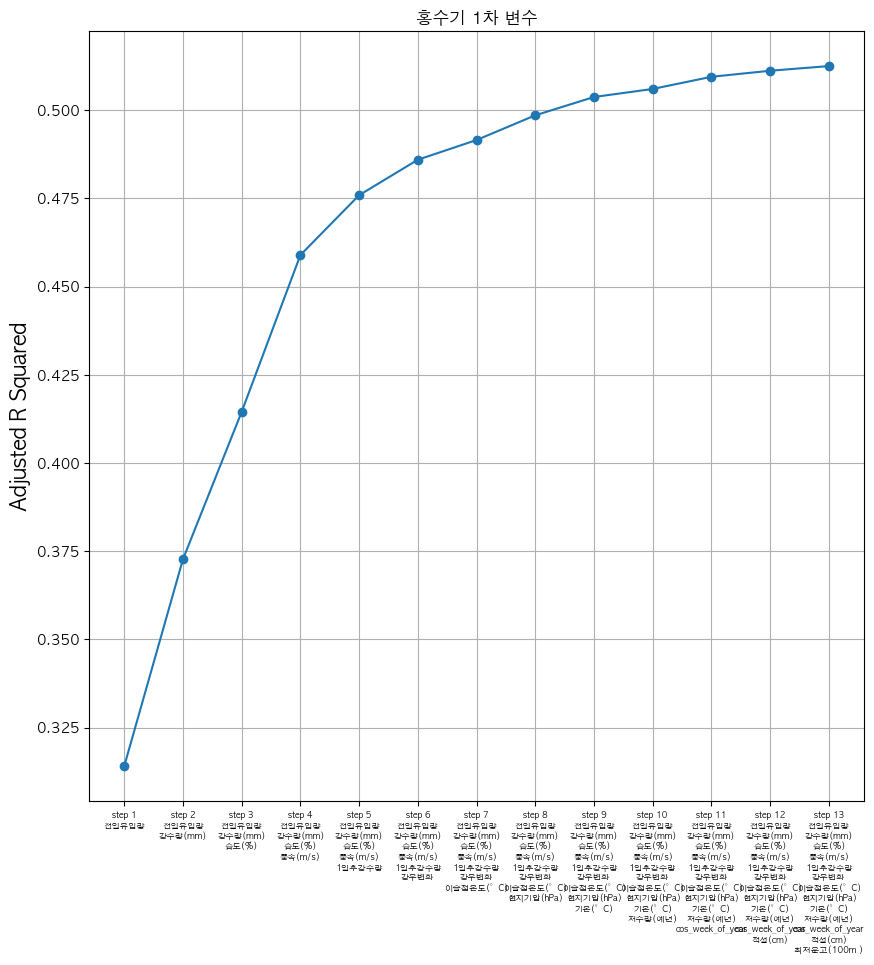

In [42]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
 
df = data_flood.copy()
## 전진 단계별 선택법
# variables = df.columns[:-2].tolist() ## 설명 변수 리스트
variables = data_flood_x.columns.tolist()
 
# y = df['Survival_Time'] ## 반응 변수
y=data_flood_y.copy()
selected_variables_flood = [] ## 선택된 변수들
sl_enter = 0.05
sl_remove = 0.05
 
sv_per_step = [] ## 각 스텝별로 선택된 변수들
adjusted_r_squared = [] ## 각 스텝별 수정된 결정계수
steps = [] ## 스텝
step = 0
while len(variables) > 0:
    remainder = list(set(variables) - set(selected_variables_flood))
    pval = pd.Series(index=remainder) ## 변수의 p-value
    ## 기존에 포함된 변수와 새로운 변수 하나씩 돌아가면서 
    ## 선형 모형을 적합한다.
    for col in remainder: 
        X = df[selected_variables_flood+[col]]
        X = sm.add_constant(X)
        model = sm.OLS(y,X).fit()
        pval[col] = model.pvalues[col]
 
    min_pval = pval.min()
    if min_pval < sl_enter: ## 최소 p-value 값이 기준 값보다 작으면 포함
        selected_variables_flood.append(pval.idxmin())
        ## 선택된 변수들에대해서
        ## 어떤 변수를 제거할지 고른다.
        while len(selected_variables_flood) > 0:
            selected_X = df[selected_variables_flood]
            selected_X = sm.add_constant(selected_X)
            selected_pval = sm.OLS(y,selected_X).fit().pvalues[1:] ## 절편항의 p-value는 뺀다
            max_pval = selected_pval.max()
            if max_pval >= sl_remove: ## 최대 p-value값이 기준값보다 크거나 같으면 제외
                remove_variable = selected_pval.idxmax()
                selected_variables_flood.remove(remove_variable)
            else:
                break
        
        step += 1
        steps.append(step)
        adj_r_squared = sm.OLS(y,sm.add_constant(df[selected_variables_flood])).fit().rsquared_adj
        adjusted_r_squared.append(adj_r_squared)
        sv_per_step.append(selected_variables_flood.copy())
    else:
        break
fig = plt.figure(figsize=(10,10))
fig.set_facecolor('white')
 
plt.xticks(steps,[f'step {s}\n'+'\n'.join(sv_per_step[i]) for i,s in enumerate(steps)], fontsize=6)
plt.plot(steps,adjusted_r_squared, marker='o')
plt.title('홍수기 1차 변수')
    
plt.ylabel('Adjusted R Squared',fontsize=15)
plt.grid(True)
plt.show()


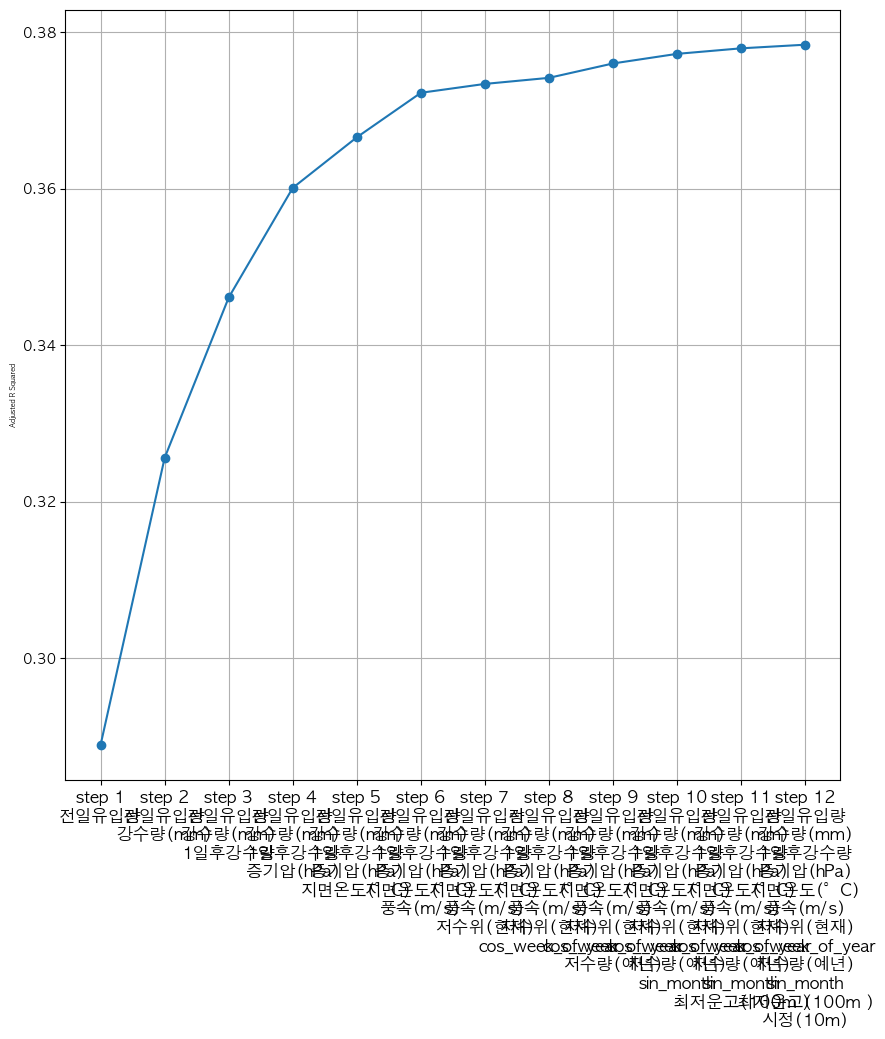

In [21]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
 
df = data_notflood.copy()
## 전진 단계별 선택법
# variables = df.columns[:-2].tolist() ## 설명 변수 리스트
variables = data_notflood_x.columns.tolist()
 
# y = df['Survival_Time'] ## 반응 변수
y=data_notflood_y.copy()
selected_variables_notflood = [] ## 선택된 변수들
sl_enter = 0.05
sl_remove = 0.05
 
sv_per_step = [] ## 각 스텝별로 선택된 변수들
adjusted_r_squared = [] ## 각 스텝별 수정된 결정계수
steps = [] ## 스텝
step = 0
while len(variables) > 0:
    remainder = list(set(variables) - set(selected_variables_notflood))
    pval = pd.Series(index=remainder) ## 변수의 p-value
    ## 기존에 포함된 변수와 새로운 변수 하나씩 돌아가면서 
    ## 선형 모형을 적합한다.
    for col in remainder: 
        X = df[selected_variables_notflood+[col]]
        X = sm.add_constant(X)
        model = sm.OLS(y,X).fit()
        pval[col] = model.pvalues[col]
 
    min_pval = pval.min()
    if min_pval < sl_enter: ## 최소 p-value 값이 기준 값보다 작으면 포함
        selected_variables_notflood.append(pval.idxmin())
        ## 선택된 변수들에대해서
        ## 어떤 변수를 제거할지 고른다.
        while len(selected_variables_notflood) > 0:
            selected_X = df[selected_variables_notflood]
            selected_X = sm.add_constant(selected_X)
            selected_pval = sm.OLS(y,selected_X).fit().pvalues[1:] ## 절편항의 p-value는 뺀다
            max_pval = selected_pval.max()
            if max_pval >= sl_remove: ## 최대 p-value값이 기준값보다 크거나 같으면 제외
                remove_variable = selected_pval.idxmax()
                selected_variables_notflood.remove(remove_variable)
            else:
                break
        
        step += 1
        steps.append(step)
        adj_r_squared = sm.OLS(y,sm.add_constant(df[selected_variables_notflood])).fit().rsquared_adj
        adjusted_r_squared.append(adj_r_squared)
        sv_per_step.append(selected_variables_notflood.copy())
    else:
        break
fig = plt.figure(figsize=(10,10))
fig.set_facecolor('white')
 
font_size = 5
plt.xticks(steps,[f'step {s}\n'+'\n'.join(sv_per_step[i]) for i,s in enumerate(steps)], fontsize=12)
plt.plot(steps,adjusted_r_squared, marker='o')
    
plt.ylabel('Adjusted R Squared',fontsize=font_size)
plt.grid(True)
plt.show()


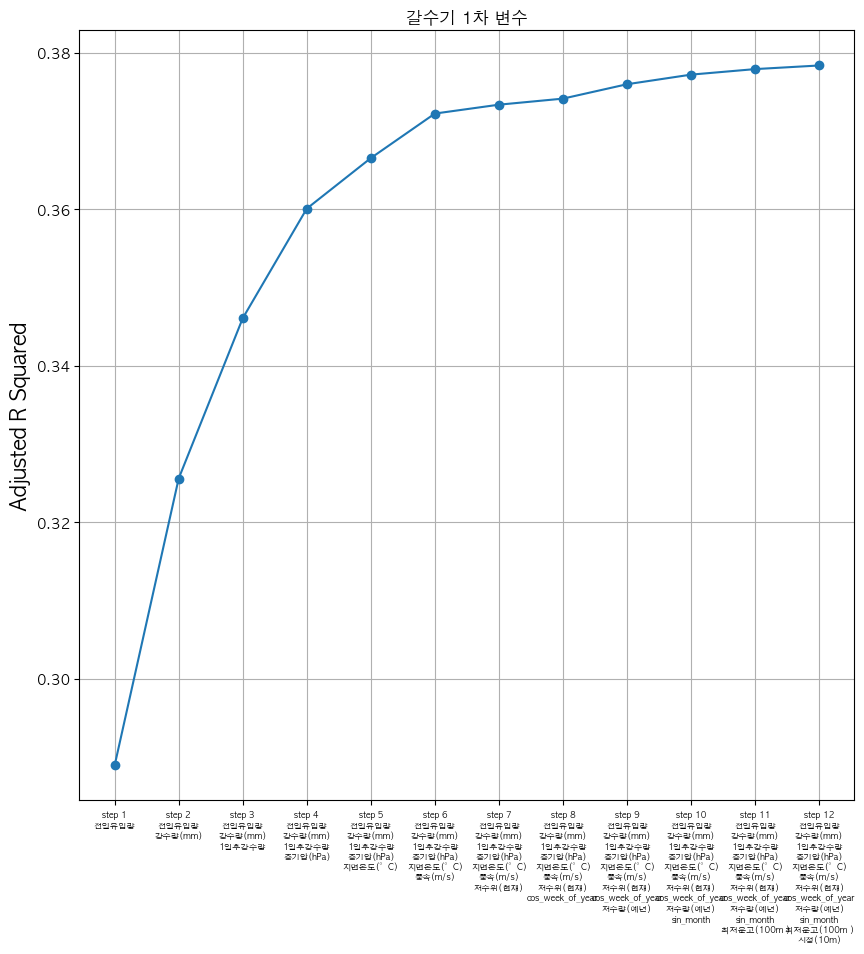

In [40]:
fig = plt.figure(figsize=(10,10))
fig.set_facecolor('white')
 
font_size = 15
plt.xticks(steps,[f'step {s}\n'+'\n'.join(sv_per_step[i]) for i,s in enumerate(steps)], fontsize=6)
plt.plot(steps,adjusted_r_squared, marker='o')
plt.title('갈수기 1차 변수')
plt.ylabel('Adjusted R Squared',fontsize=font_size)
# plt.xlabel(fontsize=font_size)
plt.grid(True)
plt.show()

In [22]:
print(len(selected_variables_flood))
print(len(selected_variables_notflood))


13
12


In [23]:
newdf_flood = data_flood_x[selected_variables_flood]
vif = pd.DataFrame()
vif["VIF Factor"] = [format(variance_inflation_factor(
    newdf_flood.values, i),'f') for i in range(newdf_flood.shape[1])]
vif["features"] = newdf_flood.columns
vif.sort_values("VIF Factor")


,VIF Factor,features
0,1.457463,전일유입량
4,1.797571,1일후강수량
1,1.829640,강수량(mm)
2,1226.490576,습도(%)
6,13277.441508,이슬점온도(°C)
11,2.032458,적설(cm)
10,20.864842,cos_week_of_year
7,21.072439,현지기압(hPa)
12,3.152351,최저운고(100m )
9,41.119301,저수량(예년)


In [28]:
fd = newdf_flood.drop(['이슬점온도(°C)','기온(°C)', '저수량(예년)', '습도(%)', '현지기압(hPa)'], axis=1)
vif2 = pd.DataFrame()
vif2["VIF Factor"] = [format(variance_inflation_factor(
    fd.values, i),'f') for i in range(fd.shape[1])]
vif2["features"] = fd.columns
vif2.sort_values("VIF Factor")



,VIF Factor,features
0,1.374429,전일유입량
3,1.749466,1일후강수량
1,1.760171,강수량(mm)
6,1.978656,적설(cm)
5,1.987279,cos_week_of_year
7,2.385766,최저운고(100m )
2,3.234866,풍속(m/s)
4,5.250281,강우변화


In [29]:
vif2['features'].values

array(['전일유입량', '강수량(mm)', '풍속(m/s)', '1일후강수량', '강우변화',
       'cos_week_of_year', '적설(cm)', '최저운고(100m )'], dtype=object)

In [30]:
newdf_notflood = data_notflood_x[selected_variables_notflood]
vif3 = pd.DataFrame()
vif3["VIF Factor"] = [format(variance_inflation_factor(
    newdf_notflood.values, i),'f') for i in range(newdf_notflood.shape[1])]
vif3["features"] = newdf_notflood.columns
vif3.sort_values("VIF Factor")

,VIF Factor,features
0,1.274585,전일유입량
3,12.563176,증기압(hPa)
9,15.072567,sin_month
2,2.262920,1일후강수량
1,2.311789,강수량(mm)
10,2.804257,최저운고(100m )
7,26.720194,cos_week_of_year
11,3.983926,시정(10m)
4,30.216309,지면온도(°C)
8,34.412398,저수량(예년)


In [32]:
fd2 = newdf_notflood.drop(['저수량(예년)','지면온도(°C)'], axis=1)
vif4 = pd.DataFrame()
vif4["VIF Factor"] = [format(variance_inflation_factor(
    fd2.values, i),'f') for i in range(fd2.shape[1])]
vif4["features"] = fd2.columns
vif4.sort_values("VIF Factor")



,VIF Factor,features
0,1.258746,전일유입량
2,2.234650,1일후강수량
1,2.264597,강수량(mm)
8,2.677296,최저운고(100m )
3,3.156347,증기압(hPa)
7,3.694385,sin_month
9,3.768772,시정(10m)
4,5.425889,풍속(m/s)
6,5.844477,cos_week_of_year
5,7.730569,저수위(현재)


In [33]:
vif4['features'].values

array(['전일유입량', '강수량(mm)', '1일후강수량', '증기압(hPa)', '풍속(m/s)', '저수위(현재)',
       'cos_week_of_year', 'sin_month', '최저운고(100m )', '시정(10m)'],
      dtype=object)

In [ ]:
dfc = data.corr()
plt.rcParams["figure.figsize"] = (20,20)

mask = np.zeros_like(dfc, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# 히트맵을 그린다
sns.heatmap(dfc, 
            cmap = 'RdYlBu_r', 
            annot = True,   # 실제 값을 표시한다
            mask=mask,      # 표시하지 않을 마스크 부분을 지정한다
            linewidths=.5,  # 경계면 실선으로 구분하기
            cbar_kws={"shrink": .5},# 컬러바 크기 절반으로 줄이기
            vmin = -1,vmax = 1   # 컬러바 범위 -1 ~ 1
           )  
plt.show()

In [ ]:
plt.rcParams["figure.figsize"] = (20,20)
sns.pairplot(data,corner=True)

In [ ]:
data = pd.read_csv(f'../data/data/합천_댐기상종합_forTrain4_scaled.csv',
                       encoding="utf-8-sig", index_col=0)
# data.index = pd.to_datetime(data.index)
data.head()

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(data.전일유입량.diff())

In [ ]:

sns.lineplot(dailyDf, x=dailyDf.index, y='전일유입량')
# sns.lineplot(dailyDf, x='시간', y='발전량(실적)', label="실적량")
plt.ylabel("(mm)")
plt.title("전체 전일유입량")

In [ ]:
# plot with 2 different axes for a dataset with different scales
# left side

fig, ax1 = plt.subplots()
fig = plt.figure(figsize=(56,9))
plt.rcParams["figure.figsize"] = (14,4)


color_1 = 'tab:blue'
ax1.set_title('실적 발전량과 계획대비 발전률')
ax1.set_ylabel('실적발전량', color=color_1)
ax1.plot(dailyDf.index, dailyDf['발전량(실적)'], color=color_1)
ax1.tick_params(axis='y', labelcolor=color_1)

# right side with different scale
ax2 = ax1.twinx() # instantiate a second axes that shares the same x-axis
color_2 = 'tab:red'
ax2.set_ylabel('계획대비 발전률', color=color_2)
ax2.plot(dailyDf.index, dailyDf['발전량(계획대비)'],  color=color_2)
ax2.tick_params(axis='y', labelcolor=color_2)


fig.tight_layout()
plt.show()

In [ ]:
sns.lineplot((dailyDf['발전량(실적)']-dailyDf['발전량(계획)']))
plt.title("전체 실적발전량-계획발전량")
plt.ylabel('(MwH)')
plt.axhline(0)

In [ ]:
dailyDf['실적-계획'] = np.where((dailyDf['발전량(실적)']-dailyDf['발전량(계획)'])>=0 , '초과' , '부족')
dailyDf['실적-계획'] = np.where((dailyDf['발전량(실적)']-dailyDf['발전량(계획)'])==0 , '적절계획' , dailyDf['실적-계획'])



In [ ]:
df2016 = dailyDf['2016-01-01 00:00:00': '2017-01-01 00:00:00']
df2017 = dailyDf['2017-01-01 00:00:00': '2018-01-01 00:00:00']
df2018 = dailyDf['2018-01-01 00:00:00': '2019-01-01 00:00:00']
df2019 = dailyDf['2019-01-01 00:00:00': '2020-01-01 00:00:00']
df2020 = dailyDf['2020-01-01 00:00:00': '2021-01-01 00:00:00']
df2021 = dailyDf['2021-01-01 00:00:00': '2022-01-01 00:00:00']



In [ ]:
plt.figure(figsize=(20,15))
plt.title('16-21 전일유입량')

plt.subplot(3,2,1)
plt.plot(df2016.index, df2016['전일유입량'])
plt.title('2016')

plt.subplot(3,2,2)
plt.plot(df2017.index, df2017['전일유입량'])
plt.title('2017')

plt.subplot(3,2,3)
plt.plot(df2018.index, df2018['전일유입량'])
plt.title('2018')

plt.subplot(3,2,4)
plt.plot(df2019.index, df2019['전일유입량'])
plt.title('2019')

plt.subplot(3,2,5)
plt.plot(df2020.index, df2020['전일유입량'])
plt.title('2020')

plt.subplot(3,2,6)
plt.plot(df2021.index, df2021['전일유입량'])
plt.title('2021')



In [ ]:
dailyDf['실적-계획'].unique()

In [ ]:
plt.pie(dailyDf['실적-계획'].value_counts(), labels=dailyDf['실적-계획'].unique(),autopct='%1.1f%%', startangle=90, explode=(0.1,0,0))
plt.title("계획발전량과 실적발전량 비교")